In [1]:
from pathlib import Path, os
import numpy as np
from glob import glob
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
import heapq
import seaborn as sns
import random

# General Approach:

* The general idea is to learn the important features from the training images and classify the validation images based on these features.
* We want a bag of visual words representaion just like in text classification for our model.
* So the steps are:
    1. Read all the training images.
    2. Extract the important features from the images using any feature detector (SIFT used in this case).
    3. Convert the features to a descriptor array.
    4. Train Kmeans on this data to get the n cluster centers.
    5. Use these cluster centers to construct a histogram for each image by:
        * Find the cluster for each image feature.
        * Increment the frequency for that cluster for the current image in our histogram.
    6. Now that all the histograms of training images are ready, read the validation data.
    7. Convert the validation image to histogram using previous kmeans model.
    8. Find the k nearest neighbors to this histogram and predict the class as the maximum occurring label in the KNN list.
    9. Compute the accuracy.

# Feature Detection - Extraction:

* We are using the SIFT feature detector for this data.
* The cv library method detects the features in an image stored in the keypoints object.
* This method also gives us the descriptor array, which is useful to train our model.
* These features are drawn back on the image using the keypoints object.

# Visual Dictionary Compilation

* After running the Kmeans algorithm, we get the cluster centers.
* This is essentially our visual word dictionary, which we will use to generate the histograms for each image.
* But these cluster centers may not correspond to actual features in our training images.
* Hence, to visualize them, we have to find the actual feature nearest to these centers.
* Then we can extract the patch from the original image for this feature.
* Finally, we plot these features to get a 10 by 10 visual dictionary.

# Bag-of-words Creation

* Now that we have our cluster centers, we can create the bag of words representation.
* The cluster centers are essentially the most important features from our training day.
* Hence, for each feature in the training image, we find the cluster it belongs to and increment the frequency for that cluster by one.
* So for each image we get an n-dimensional array (histogram with n being the number of cluster centers) that tells us which feature occurred how many times in that image.
* These histograms will be used for our final KNN classification.

# Classification via Visual Words

* After generating our histograms, we can finally classify our validation images using KNN classification.
* The idea is to generate a similar histogram as for our training images (using the kmeans model).
* Then we find the k closest training histograms (associated to a single training image).
* Finally, we can use the actual labels or class of these k images to predict the class of our valdiation image. It will simply be the maximum occurring class in the list of k elements.
* We find the k nearest neighbors using the following algorithm:
    1. Insert the distance between the validation image histogram and other training images histograms into a heap data structure.
    2. Remove an element k number of times to get the k closest histograms.
    3. Return the class labels of these histograms.
* Heap is a tree-like data structure where each node is smaller (in our case, also called Min-Heap) than its children nodes.
* Hence, the root is the smallest element of all. Since in our case when we maintain heap by distance, we get the closest histograms.

In [2]:
def visualize_features(image, keypoints, label):
    '''
    plots the image with and without the features
    '''
    copy = image.copy()
    copy = cv.drawKeypoints(image, keypoints, copy, 
                            flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(image, 'gray')
    axes[0].set_title('Original image')
    axes[0].axis('off')
    axes[1].imshow(copy)
    axes[1].set_title('After feature detection')
    axes[1].axis('off')
    fig.suptitle(f'Image from class {label}')
    fig.tight_layout()
    plt.savefig(str(op_path / f'{label}.png'))
    plt.show()
    print('\n\n')

In [3]:
def visualize_dictionary(dict_ele):
    '''
    Plots the visual word dictionary (from features closest to the cluster centers)
    '''
    plt.figure(figsize=(15, 15))
    for i in range(10):
        for j in range(10):
            cur, keypoint = dict_ele[i*10+j]
            size = 11
            
            start_x = int(keypoint.pt[0] - size / 2.)
            start_y = int(keypoint.pt[1] - size / 2.)
            patch = train_images[cur][start_y: start_y+size, start_x: start_x+size]
            
            ax = plt.subplot2grid((10, 10), (i, j))
            plt.suptitle('Visual Word Dictionary', fontsize=50)
            ax.imshow(patch, 'gray')
            ax.axis('off')
    plt.savefig(str(op_path / 'visual_dict.png'))
    plt.show()  

In [4]:
def fit_kmeans(n_clusters, visualize=False):
    '''
    Fits the data on the kmeans model and visualizes it.
    '''
    kmeans = KMeans(n_clusters=n_clusters).fit(np.concatenate(train_descriptors))
    
    if visualize:
        # visualize the dictionary
        closest = pairwise_distances_argmin(kmeans.cluster_centers_, np.concatenate(train_descriptors))
        closest.sort()
        i = j = 0
        dict_ele = []
        for image_index in range(len(train_keypoints)):
            for keypoint in train_keypoints[image_index]:
                if j < len(closest) and i == closest[j]:
                    dict_ele.append((image_index, keypoint))
                    j += 1
                i += 1
        visualize_dictionary(dict_ele)
        
    std, train_histograms = create_histograms(kmeans, n_clusters)
        
    return kmeans, std, train_histograms

In [5]:
def create_histograms(kmeans, n_clusters):
    '''
    Creates histograms for the training images
    '''
    
    # build training histograms
    train_histograms = []
    for des in train_descriptors:
        predictions = kmeans.predict(des)
        histogram, _ = np.histogram(predictions, bins=n_clusters)
        train_histograms.append(histogram)

    # normalize the histograms
    train_histograms = np.array(train_histograms)
    std = np.std(train_histograms, axis=0)
    train_histograms = train_histograms / std
    
    return std, train_histograms

In [6]:
 def predict_validation(train_histograms, k):
    '''
    Predicts for the validation images and calculates the accuracy
    '''
    # read the validation data
    accuracy = 0
    val_images, val_true_labels, val_pred_labels, labels = [], [], [], []
    for folder in glob(str(val_path)):
        true_label = folder.split(os.sep)[-1]
        labels.append(true_label)
        for file in glob(folder + '/*.jpg'):
            image = cv.imread(file, -1)
            val_images.append(image)
            _, des = sift.detectAndCompute(image, None)

            predictions = kmeans.predict(des)
            histogram, _ = np.histogram(predictions, bins=n_clusters)
            histogram = histogram / std

            knn = get_knn(train_histograms=train_histograms,
                          train_labels=train_labels,
                          val_histogram=histogram, k=k)
            pred_label = max(set(knn), key=knn.count)

            val_true_labels.append(true_label)
            val_pred_labels.append(pred_label)
            
            if true_label == pred_label:
                accuracy += 1
      
    accuracy = accuracy * 100 / len(val_pred_labels)
    print(f'Accuracy: {accuracy}%')
    return accuracy, labels, val_pred_labels, val_true_labels, val_images

In [7]:
def get_knn(train_histograms, train_labels, val_histogram, k):
    '''
    returns the k nearest neighbors for the histograms.
    '''
    heap = []
    heapq.heapify(heap)
    for histogram, label in zip(train_histograms, train_labels):
        dist = 0
        for val1, val2 in zip(histogram, val_histogram):
            dist += np.square(val1 - val2)
        dist = np.sqrt(dist)
        heapq.heappush(heap, (dist, label))
        
    return [heapq.heappop(heap)[1] for _ in range(k)]

In [8]:
def visualize_confusion_matrix(accuracy, labels, val_pred_labels, val_true_labels):
    '''
    Plots the confusion matrix for given data.
    '''
    confusion_matrix = np.zeros((10, 10), dtype=np.int16)
    for pred, true in zip(val_pred_labels, val_true_labels):
        confusion_matrix[labels.index(pred), labels.index(true)] += 1
    confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1,keepdims=1)
    
    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(confusion_matrix, annot=True, square=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
    ax.set_title(f'Confusion Matrix (Accuracy = {accuracy}%)', fontsize=50)
    ax.set_xticklabels(labels, fontsize=15)
    ax.set_yticklabels(labels, fontsize=15)
    ax.set_xlabel("True Label", fontsize=25)
    ax.set_ylabel("Predicted Label", fontsize=25)
    plt.savefig(str(op_path / 'confusion_matrix.png'))
    plt.show()

In [9]:
# set the file paths
root_path = Path.cwd()
train_path = root_path / 'data' / 'train' / '*'
val_path = root_path / 'data' / 'validation' / '*'
op_path = root_path / 'Results'

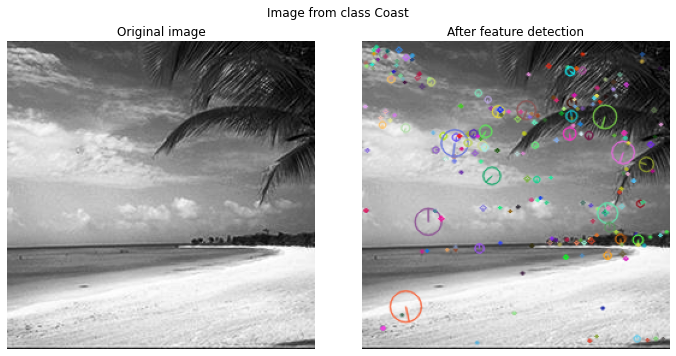

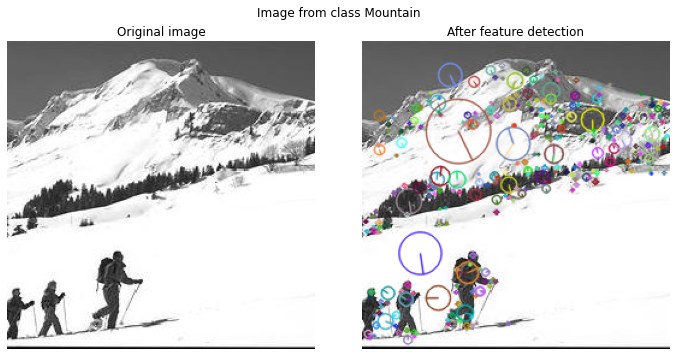

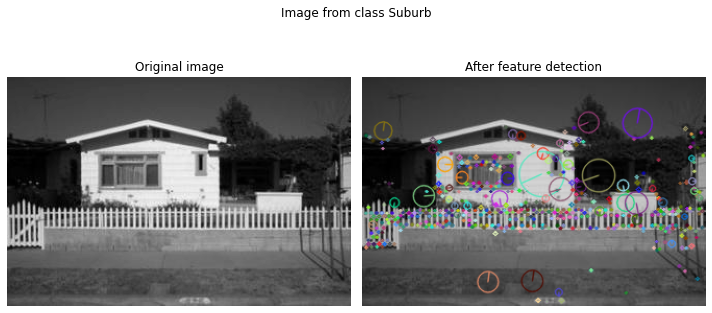

In [10]:
# create sift descriptor and read the training data
sift = cv.SIFT_create()
train_images, train_labels, train_keypoints, train_descriptors = [], [], [], []
for folder in glob(str(train_path)):
    label = folder.split(os.sep)[-1]
    for file in glob(folder + '/*.jpg'):
        image = cv.imread(file, -1)
        kp, des = sift.detectAndCompute(image, None)

        train_images.append(image)
        train_labels.append(label)
        train_keypoints.append(kp)
        train_descriptors.append(des)

# visualize the feature detection
for i in range(0, 500, 200):
    visualize_features(train_images[i], train_keypoints[i], train_labels[i])

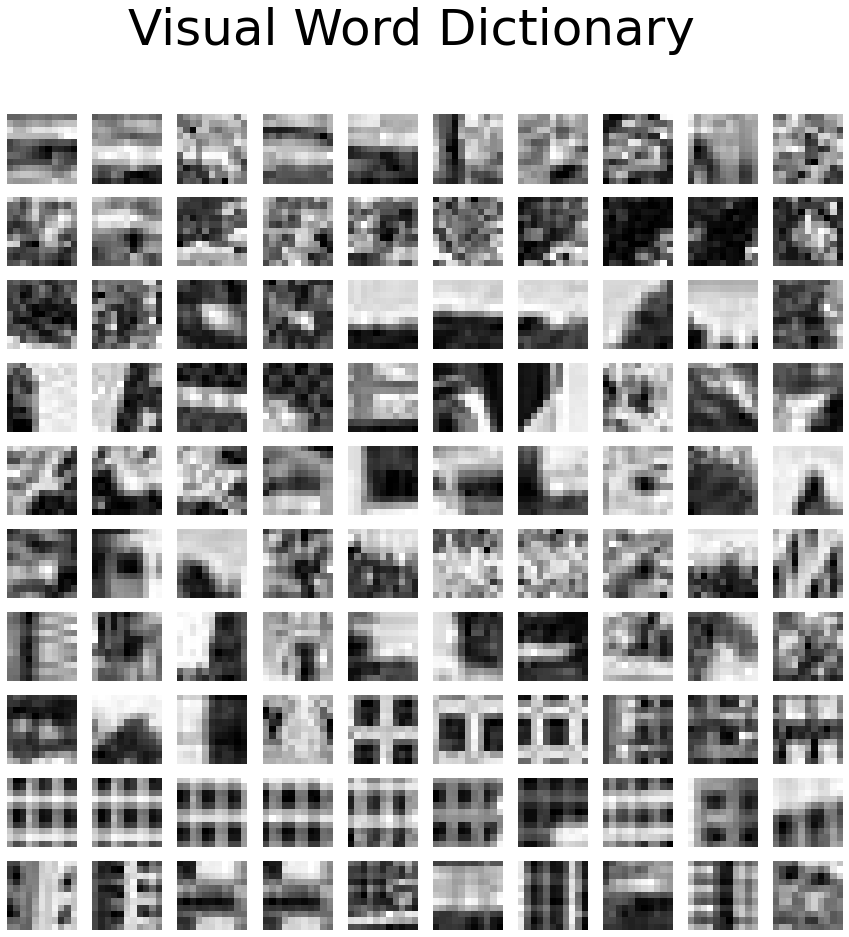

In [11]:
# call kmeans for 100 clusters
n_clusters = 100
kmeans, std, train_histograms = fit_kmeans(n_clusters=n_clusters, visualize=True)

Accuracy: 50.8%


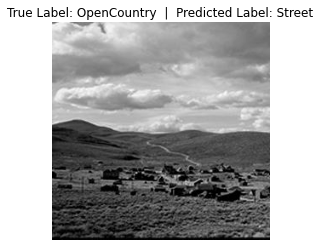

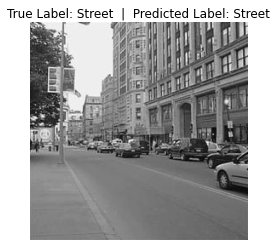

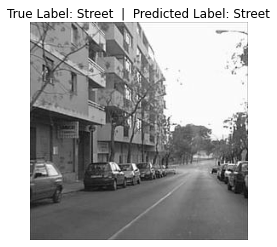

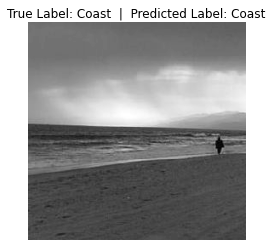

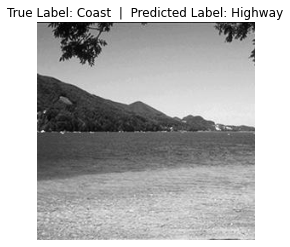

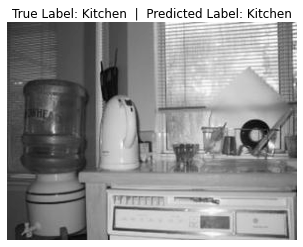

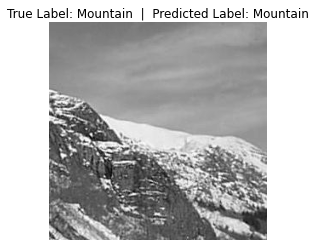

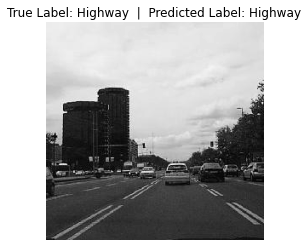

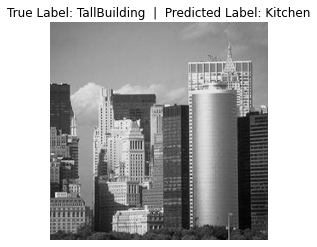

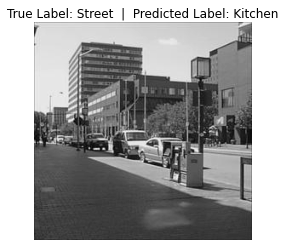

In [12]:
# predict and plot predictions for 10 random images for k = 5 in KNN
accuracy_1, labels, val_pred_labels, val_true_labels, val_images = predict_validation(train_histograms, k=5)

indices = random.sample(range(len(val_pred_labels)), 10)
for i in indices:
    image = val_images[i]
    true_label = val_true_labels[i]
    pred_label = val_pred_labels[i]
    
    plt.title(f'True Label: {true_label}  |  Predicted Label: {pred_label}')
    plt.imshow(image, 'gray')
    plt.axis('off')
    plt.savefig(str(op_path / f'{true_label}.png'))
    plt.show()
    print('\n')

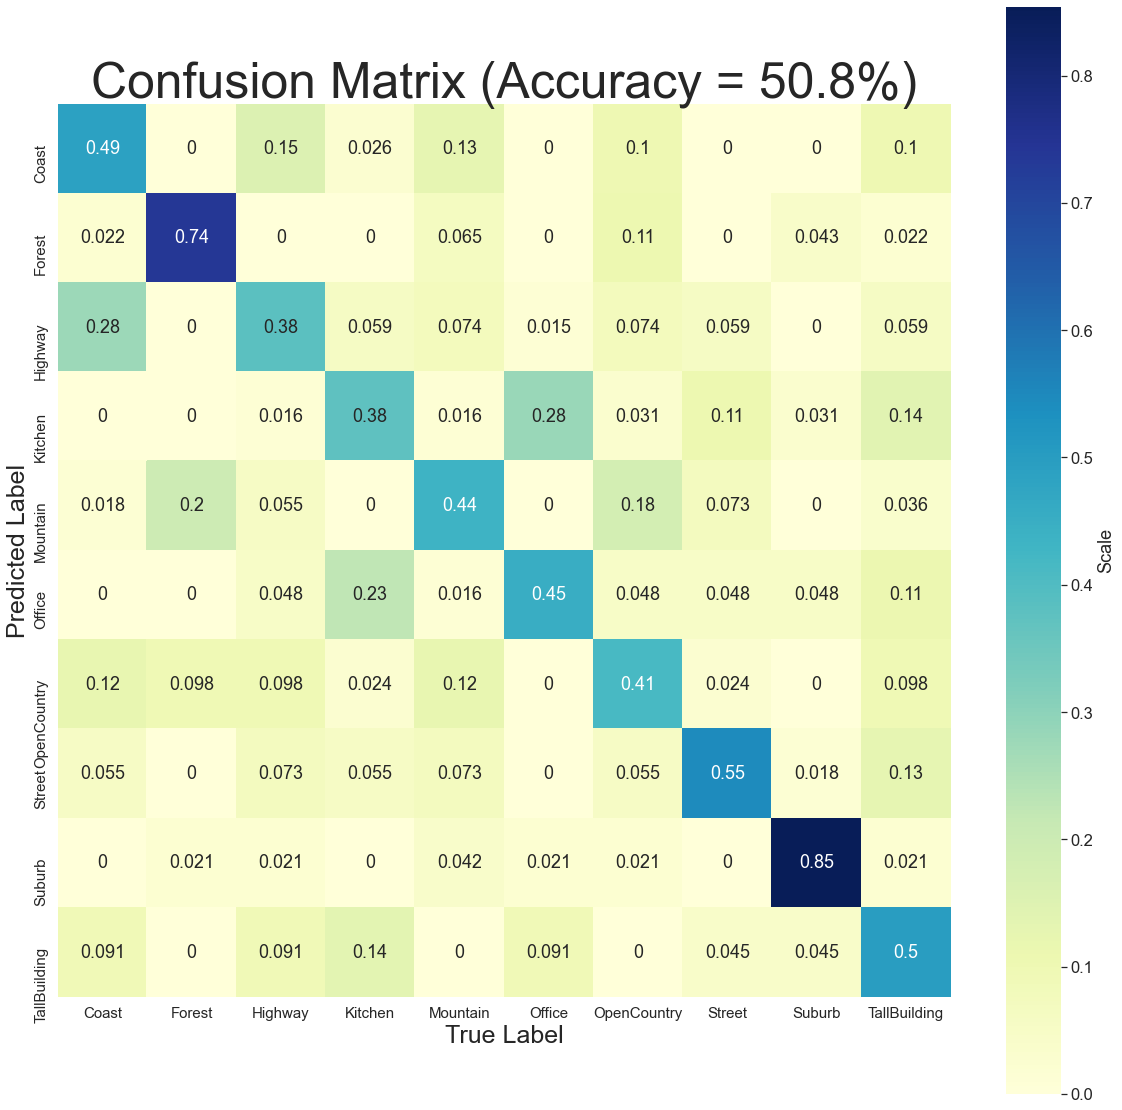

In [13]:
# visualize the confusion matrix
visualize_confusion_matrix(accuracy_1, labels, val_pred_labels, val_true_labels)

In [14]:
# predict for k = 1 in KNN
accuracy_2, _, _, _, _ = predict_validation(train_histograms, k=1)

Accuracy: 46.4%


In [15]:
# predict for k = 10 in KNN
accuracy_3, _, _, _, _ = predict_validation(train_histograms, k=10)

Accuracy: 49.2%


In [16]:
# run kmeans for 25 clusters and predict
n_clusters = 25
kmeans, std, train_histograms = fit_kmeans(n_clusters=n_clusters)
accuracy_4, _, _, _, _ = predict_validation(train_histograms, k=5)

Accuracy: 48.0%


In [17]:
print('-'*88)
print('Sr. No.      Number of clusters (Kmeans)      Number of Neighbors (KNN)      Accuracy (%)')
print('-'*88)
print('-'*88)
print(f'1                      100                              5                        {accuracy_1}')
print('-'*88)
print(f'2                      100                              1                        {accuracy_2}')
print('-'*88)
print(f'3                      100                             10                        {accuracy_3}')
print('-'*88)
print(f'4                      25                               5                        {accuracy_4}')
print('-'*88)

----------------------------------------------------------------------------------------
Sr. No.      Number of clusters (Kmeans)      Number of Neighbors (KNN)      Accuracy (%)
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
1                      100                              5                        50.8
----------------------------------------------------------------------------------------
2                      100                              1                        46.4
----------------------------------------------------------------------------------------
3                      100                             10                        49.2
----------------------------------------------------------------------------------------
4                      25                               5                        48.0
--------------------------------

# Analysis

* Our SIFT feature detector can clearly identify the important features in the images as can be seen in the plots.
* The main points, edges, corners are clearly identified.
* This can also be seen in the kmeans clusters.
* After plotting the cluster center patches, we can observe some horizontal, vertical lines as well as sharp corners and grid-like lines.
* Our kmeans algorithm has clearly worked well.
* Finally, after the predictions and plotting the confusion matrix, we can see that our model does very well.
* Forest and suburb images are classified with high accuracy while the rest also get pretty decent accuracies.
* We can also see from the confusion matrix that our model often confused an Office as a Kitchen. The same also happened between Mountain and Open Country.
* So we can collect more training images for these classes for further better accuracy.
* We ran our model for two Kmeans parameters (number of clusters):
    1. 100 clusters.
    2. 25 clusters.
* The 100 cluster model consistently gave 50% plus accuracy, but when the clusters were dropped to just 25, the accuracy also dropped.
* This shows that lesser number of clusters means our model is also less diverse. While high number of clusters will lead to extremely slow training times.
* So it is better to keep a balance between the kmeans clusters.
* Also we tried the KNN on three different parameters:
    1. k = 1.
    2. k = 5.
    3. k = 10.
* Even though these three values did not budge the validation accuracy much, but on-average k = 5 gave the best accuracy.
* The k value should not be set to too low as the prediction can be affected by noise.
* And higher k value means our model will be too general. Hence, at the end k = 5 was chosen as it gave consistent 50% plus accuracy results.
* Hence, the confusion matrix is plotted for this model (100 clusters and k = 5).